In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [17]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)
len(subset_symbols),subset_symbols[1]

(352, 'XRP')

In [69]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(100)):
    with open(f"2_0_0_analysisdata/2_0_3_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list = pickle.load(f)
    dfmpl_list_list.append( dfmpl_list.copy())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.20it/s]


In [71]:
%%time
for symm in subset_symbols:
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    if not all(np.diff(df_.index,2).astype(float)==0):
        print(symm)

ARKMUSDT
MAVUSDT
PENDLEUSDT
COMBOUSDT
WBETHUSDT
QUICKUSDT
WLDUSDT
CPU times: total: 5.64 s
Wall time: 7.41 s


# concat the dfs, store into a list of dfs, also store a list of corresponding symbols

In [161]:
dfmpl_list = []

for idd,symm in tqdm.tqdm(enumerate(subset_symbols[:])):
    #if idd<110:continue
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    dfmpl_list.append( (df__.copy(),symm,idd) )
    #if symm =="COMBOUSDT":
    #    break

352it [00:11, 31.56it/s]


In [169]:
for df__,symm,idd in dfmpl_list:
    if not all(np.diff(df__.index,2).astype(float)==0):
        print(symm)


QUICKUSDT


In [167]:
np.where(np.diff(df__.index,2).astype(float)!=0)

(array([67377, 67378], dtype=int64),)

In [168]:
df__.iloc[67377:67377+3]

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-17 10:58:00,73.9000,74.100,73.80000,74.00000,42.172
2023-07-17 10:59:00,73.9000,74.200,73.40000,74.20000,332.559
2023-07-21 16:00:00,0.0742,0.079,0.06166,0.06508,7582716.000


In [67]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
vol = dfmpl.Volume*dfmpl.Open

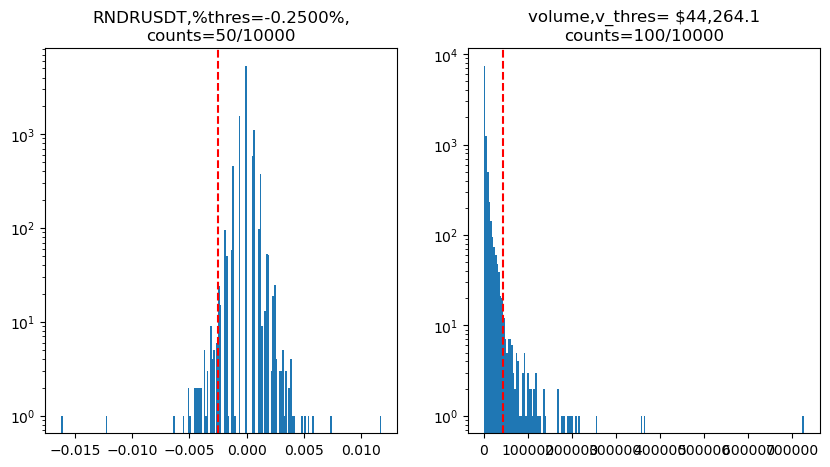

In [68]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
#percentile_threshold = np.percentile(v,99.9)
percentile_threshold = np.percentile(v,0.5)
ax.hist(v,bins=200);
ax.axvline(percentile_threshold,ls="--",c="r")
ax.set_title(f"{symm},%thres={percentile_threshold:.4%},\ncounts={sum(v<percentile_threshold)}/{len(v)}")
ax.set_yscale("log")
ax=axx[1]A
ax.hist(vol,bins=200);
vol_threshold = np.percentile(vol,99)
ax.axvline(vol_threshold,ls="--",c="r")
ax.set_title(f"volume,v_thres= ${vol_threshold:3,g}\ncounts={sum(vol>vol_threshold)}/{len(vol)}")
ax.set_yscale("log")

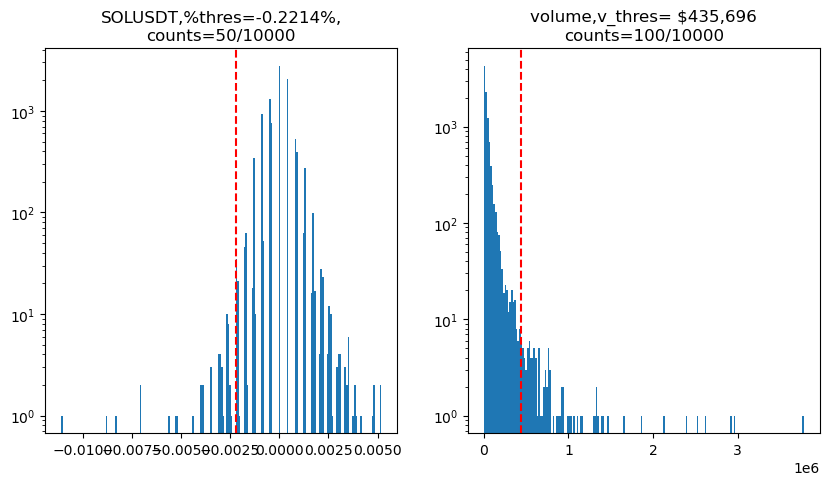

In [59]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
#percentile_threshold = np.percentile(v,99.9)
percentile_threshold = np.percentile(v,0.5)
ax.hist(v,bins=200);
ax.axvline(percentile_threshold,ls="--",c="r")
ax.set_title(f"{symm},%thres={percentile_threshold:.4%},\ncounts={sum(v<percentile_threshold)}/{len(v)}")
ax.set_yscale("log")
ax=axx[1]
ax.hist(vol,bins=200);
vol_threshold = np.percentile(vol,99)
ax.axvline(vol_threshold,ls="--",c="r")
ax.set_title(f"volume,v_thres= ${vol_threshold:3,g}\ncounts={sum(vol>vol_threshold)}/{len(vol)}")
ax.set_yscale("log")

In [61]:
4e5

400000.0

# when price falls twice in a row, 

In [62]:
%%time
threshold=-0.0022
dfmpl,tickerpair,indd = dfmpl_list[0]
collated_data_list = []
all_locs = []
for dfmpl,tickerpair,_ in dfmpl_list:
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
    a1=np.where(v<threshold)[0]
    a2=np.diff(a1)
    a3=np.where(a2==1)
    def validate_df(loc):
        df_ = dfmpl.iloc[loc:loc+2]
        v0,v1 = (df_.Open*df_.Volume).values
        if v0>4e5 and v1>4e5:
            return True
        return False
    if len(a3)>0:
        locs=a1[a3]
        if len(locs)>0:
            collated_data = np.asarray([v[loc:loc+5] for loc in locs if validate_df(loc)])
            if len(collated_data)>0:
                print(tickerpair,len(collated_data),[loc for loc in locs if validate_df(loc)])
                [all_locs.append(loc)for loc in locs if validate_df(loc)]
                collated_data_list.append(collated_data)
    #len(locs)
collated_data = np.vstack(collated_data_list)
collated_data.shape

XRPUSDT 5 [1249, 1250, 3005, 4355, 5463]
ETHUSDT 2 [1249, 1250]
SOLUSDT 2 [1250, 4356]
DOGEUSDT 4 [1108, 1250, 1628, 8413]
BNBUSDT 2 [1249, 1253]
LINKUSDT 2 [1108, 1250]
ADAUSDT 1 [1250]
MATICUSDT 3 [1250, 4356, 8413]
LTCUSDT 6 [1086, 1123, 1250, 3005, 4222, 4223]
BCHUSDT 4 [709, 1180, 1250, 9679]
COMPUSDT 1 [7526]
SHIBUSDT 11 [5441, 5449, 5450, 5467, 5468, 5482, 5517, 5862, 6120, 6815, 8413]
CRVUSDT 6 [5220, 5233, 5234, 5235, 5236, 5574]
YGGUSDT 65 [5435, 5443, 5444, 5445, 5448, 5452, 5459, 5464, 5465, 5466, 5722, 5941, 6120, 6783, 6784, 6811, 6812, 6839, 6840, 8063, 8167, 8168, 8179, 8186, 8187, 8190, 8193, 8194, 8195, 8196, 8197, 8198, 8209, 8221, 8232, 8236, 8237, 8238, 8244, 8245, 8246, 8267, 8272, 8276, 8277, 8282, 8295, 8305, 8306, 8346, 8347, 8348, 8370, 8371, 8389, 8399, 8400, 8404, 8410, 8413, 8428, 8431, 8470, 8471, 8472]
DODOUSDT 1 [9355]
KNCUSDT 1 [1027]
CPU times: total: 2.33 s
Wall time: 3.64 s


(116, 5)

In [63]:
sorted(all_locs)

[709,
 1027,
 1086,
 1108,
 1108,
 1123,
 1180,
 1249,
 1249,
 1249,
 1250,
 1250,
 1250,
 1250,
 1250,
 1250,
 1250,
 1250,
 1250,
 1253,
 1628,
 3005,
 3005,
 4222,
 4223,
 4355,
 4356,
 4356,
 5220,
 5233,
 5234,
 5235,
 5236,
 5435,
 5441,
 5443,
 5444,
 5445,
 5448,
 5449,
 5450,
 5452,
 5459,
 5463,
 5464,
 5465,
 5466,
 5467,
 5468,
 5482,
 5517,
 5574,
 5722,
 5862,
 5941,
 6120,
 6120,
 6783,
 6784,
 6811,
 6812,
 6815,
 6839,
 6840,
 7526,
 8063,
 8167,
 8168,
 8179,
 8186,
 8187,
 8190,
 8193,
 8194,
 8195,
 8196,
 8197,
 8198,
 8209,
 8221,
 8232,
 8236,
 8237,
 8238,
 8244,
 8245,
 8246,
 8267,
 8272,
 8276,
 8277,
 8282,
 8295,
 8305,
 8306,
 8346,
 8347,
 8348,
 8370,
 8371,
 8389,
 8399,
 8400,
 8404,
 8410,
 8413,
 8413,
 8413,
 8413,
 8428,
 8431,
 8470,
 8471,
 8472,
 9355,
 9679]

Text(0.5, 1.0, 'avg = +0.01%($\\pm$1.67%)')

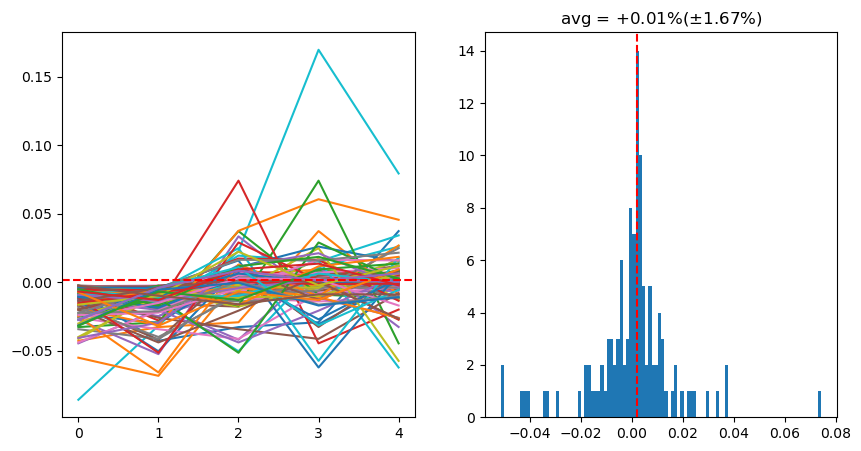

In [64]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
ax.plot(collated_data.T)
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")

In [65]:
np.product(collated_data[:,2]+1-0.003)

0.6990492232251294

# trading implementation / algo

- subscribe to all data using websockets
- within each websocket instance, fetch data
- maintain a list of previous 2 candles
- once the current candle is determined to be changed, pop the list and append the new candle
    - then apply algorithm onto this list,
    - if criteria passed, send to master_trader.

In [23]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
from binance.enums import *
import time
import datetime
from collections import Counter
import pickle

In [ ]:
master_list=[0 for _ in subset_symbols[:]]
async def main(symbol='BNBBTC',idd=0):
    global master_list
    #time.sleep(idd*)
    await asyncio.sleep(idd*0.25)
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client) 
    ts = bm.kline_socket(symbol, interval=KLINE_INTERVAL_1MINUTE) 
    print(f"sub{idd}",end=" ")
    prev="0000"
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            #print(res)
            if res["e"]=="error":
                print(str(datetime.datetime.now())[11:-4],res)
                raise Exception(res)
            #print(res["k"]["s"],str(res["E"])[6:-3],str(res["k"]["T"])[6:-3],end="  ")
            master_list[idd]=str(res["k"]["T"])[6:-3]
            if idd==0:
                if prev != str(res["k"]["T"])[6:-3]:
                    print(str(datetime.datetime.now())[11:-4],master_list[-3:],Counter(master_list))
                    prev = str(res["k"]["T"])[6:-3]
    await client.close_connection()

In [ ]:
loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for idd,s in enumerate(subset_symbols[:]):
    asyncio.run_coroutine_threadsafe(main(s+"USDT",idd), loop)
    #time.sleep(0.4)